In [1]:
def check_float(textin):
    try:
        float(textin)
        return True

    except ValueError:
        return False

def check_force(folder):
    import os
    import numpy as np
    files = os.listdir(folder)
    cleaned = [float(x) for x in files if check_float(x)]
    print(np.max(cleaned))
    if os.path.exists(folder+"/postProcessing/forces/{}".format(np.max(cleaned))):
        return False
    else:
        return True
    
def retrieve_lift(folder):
    import os
    import shutil
    import numpy as np
    
    files = os.listdir(folder)
    cleaned = [x for x in files if check_float(x)]
    files = sorted(cleaned)
    needs_forces = check_force(folder)
    print(needs_forces)
    if needs_forces:
        force_command = "rhoSimpleFoam -postProcess -case {} -func forces".format(folder)
        os.system(force_command)
    else:
        pass
    
    forces = np.zeros(3)
    moments = np.zeros(3)
    time = np.array([])
    
    for file in files:    
        with open("{}/postProcessing/forces/{}/forces.dat".format(folder,file)) as f:
            full = f.readlines()
            line = full[3]
            starts = []
            ends = []
            for i in range(len(line)):
                if line[i] == '(' and line[i+1] != '(':
                    starts.append(i+1)
                elif line[i] == ')' and line[i-1] != ')':
                    ends.append(i)
            pressure_forces = np.array([float(x) for x in line[starts[0]:ends[0]].split()])
            viscous_forces = np.array([float(x) for x in line[starts[1]:ends[1]].split()])

            pressure_moments = np.array([float(x) for x in line[starts[2]:ends[2]].split()])
            viscous_moments = np.array([float(x) for x in line[starts[3]:ends[3]].split()])
            forces = np.vstack([forces, pressure_forces + viscous_forces])
            moments = np.vstack([moments, pressure_moments + viscous_moments])
            time = np.append(time,float(file))
    return forces, moments, time     
        
def massflow_bc(case_folder = './'):
    import pyvista as pv
    import numpy as np
    import os
    bool = np.bool_
    target = case_folder + '/VTK/coandaUpper/'
    target+= os.listdir(target)[0]
    raw = pv.read(target)
    points = raw.points   
    x = raw.points[:,1]
    z = raw.points[:,2]
    w = np.max(z) - np.min(z)
    p = raw.point_data['p']
    U = raw.point_data['U']
    T = raw.point_data['T']
    R = 287

    rho = p / (R * T)
    intRhoU = np.trapz(rho*U[:,0],x)
    mdot = intRhoU * w    
    
    return mdot

x = massflow_bc()
print(x)


0.0038941016


[-1.   -0.95 -0.9  -0.85 -0.8  -0.75 -0.7  -0.65 -0.6  -0.55 -0.5  -0.45
 -0.4  -0.35 -0.3  -0.25 -0.2  -0.15 -0.1  -0.05  0.    0.05  0.1   0.15
  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55  0.6   0.65  0.7   0.75
  0.8   0.85  0.9   0.95  1.  ]


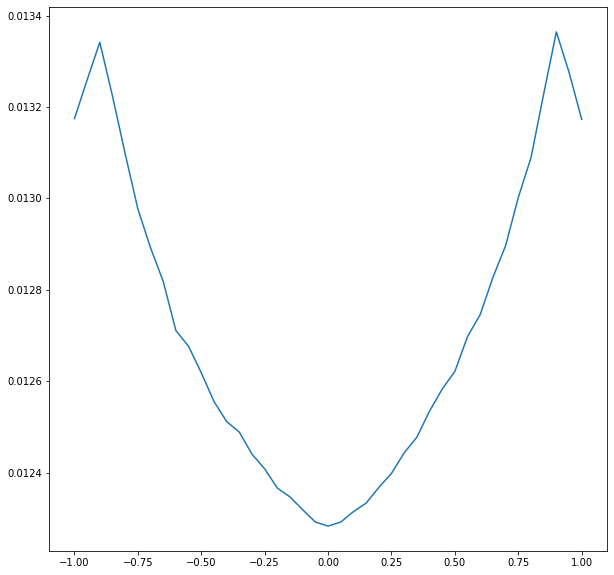

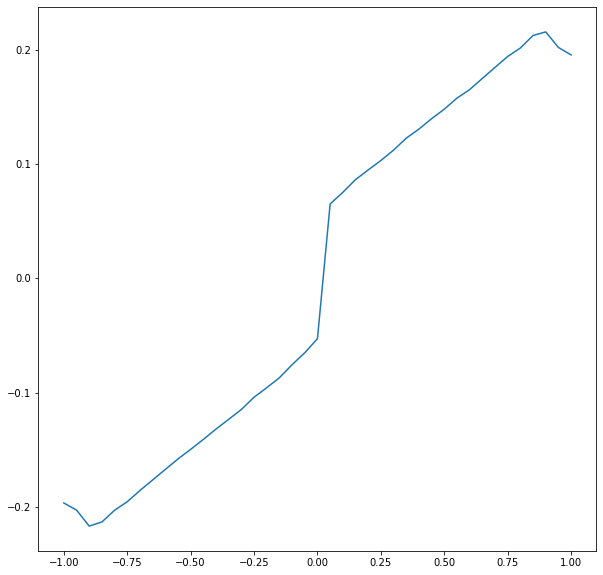

In [11]:
import numpy as np
import os
from matplotlib import pyplot as plt

data = np.loadtxt('./output/p_vs_f.txt')
pu = data[:,0]
pl = data[:,1]
cl = data[:,2]
cd = data[:,3]

direc = (pu - pl) / 5000
print(direc)

plt.figure(figsize=[10,10])
plt.plot(direc,cd)

plt.figure(figsize=[10,10])
plt.plot(direc,cl)
